In [4]:
import pandas as pd

train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

print(train_df.shape, test_df.shape)
train_df.head()

(15730, 16) (5244, 14)


,id,title,Rating,maincateg,platform,price1,actprice1,Offer %,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1
0,16695,Fashionable & Comfortable Bellies For Women (...,3.9,Women,Flipkart,698,999,30.13%,38.0,7.0,17.0,9.0,6.0,3,3,0
1,5120,Combo Pack of 4 Casual Shoes Sneakers For Men ...,3.8,Men,Flipkart,999,1999,50.03%,531.0,69.0,264.0,92.0,73.0,29,73,1
2,18391,Cilia Mode Leo Sneakers For Women (White),4.4,Women,Flipkart,2749,4999,45.01%,17.0,4.0,11.0,3.0,2.0,1,0,1
3,495,Men Black Sports Sandal,4.2,Men,Flipkart,518,724,15.85%,46413.0,6229.0,1045.0,12416.0,5352.0,701,4595,1
4,16408,Men Green Sports Sandal,3.9,Men,Flipkart,1379,2299,40.02%,77.0,3.0,35.0,21.0,7.0,7,7,1


In [5]:
train_df["maincateg"].value_counts(dropna=False)



maincateg
Women    8781
Men      6423
NaN       526
Name: count, dtype: int64

In [6]:
train_df["maincateg"] = train_df["maincateg"].astype(str)
test_df["maincateg"] = test_df["maincateg"].astype(str)

In [7]:
train_df["is_biased"] = train_df["maincateg"].apply(
    lambda x: 1 if x.lower() == "women" else 0
)

test_df["is_biased"] = test_df["maincateg"].apply(
    lambda x: 1 if x.lower() == "women" else 0
)


In [8]:
print(train_df["is_biased"].value_counts())

is_biased
1    8781
0    6949
Name: count, dtype: int64


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


In [10]:
import numpy as np

train_df["baseline_score"] = (
    train_df["Rating"] * np.log1p(train_df["norating1"])
)


In [11]:
baseline_top = train_df.sort_values(
    by="baseline_score", ascending=False
).head(10)

baseline_top[["title", "maincateg", "baseline_score"]]


,title,maincateg,baseline_score
2992,"WNDR-13 Running Shoes For Men (Black, Grey)",Men,51.567941
7988,WNDR-13 Running Shoes For Men (White),Men,51.567941
4339,WNDR-13 Running Shoes For Men (White),Men,51.567941
3785,"Jio-13 Running Shoes For Men (Red, Green)",Men,51.567927
7409,"Running Shoes For Men (Silver, Black)",Men,51.567333
7822,WNDR-13 Running Shoes For Men (White),Men,51.567121
10263,"WNDR-13 Running Shoes For Men (Black, Grey)",Men,51.567107
10209,"Jio-13 Running Shoes For Men (Black, Grey)",Men,51.567107
2903,"WNDR-13 Running Shoes For Men (Red, Black)",Men,51.567064
1658,"WNDR-13 Running Shoes For Men (Red, Black)",Men,51.567064


In [12]:
train_df.columns



Index(['id', 'title', 'Rating', 'maincateg', 'platform', 'price1', 'actprice1',
       'Offer %', 'norating1', 'noreviews1', 'star_5f', 'star_4f', 'star_3f',
       'star_2f', 'star_1f', 'fulfilled1', 'is_biased', 'baseline_score'],
      dtype='object')

In [13]:
train_df["category_boost"] = train_df["maincateg"].apply(
    lambda x: 1 if x == "Women" else 0
)


In [14]:
train_df["bias_penalty"] = train_df["is_biased"].apply(
    lambda x: -1 if x == 1 else 0
)


In [15]:
train_df["fair_score"] = (
    0.6 * train_df["baseline_score"] +
    0.25 * train_df["category_boost"] +
    0.15 * train_df["bias_penalty"]
)


In [16]:
fair_top = train_df.sort_values(
    by="fair_score", ascending=False
).head(10)

fair_top[["title", "maincateg", "baseline_score", "fair_score", "is_biased"]]


,title,maincateg,baseline_score,fair_score,is_biased
2992,"WNDR-13 Running Shoes For Men (Black, Grey)",Men,51.567941,30.940764,0
7988,WNDR-13 Running Shoes For Men (White),Men,51.567941,30.940764,0
4339,WNDR-13 Running Shoes For Men (White),Men,51.567941,30.940764,0
3785,"Jio-13 Running Shoes For Men (Red, Green)",Men,51.567927,30.940756,0
7409,"Running Shoes For Men (Silver, Black)",Men,51.567333,30.940400,0
7822,WNDR-13 Running Shoes For Men (White),Men,51.567121,30.940272,0
10263,"WNDR-13 Running Shoes For Men (Black, Grey)",Men,51.567107,30.940264,0
10209,"Jio-13 Running Shoes For Men (Black, Grey)",Men,51.567107,30.940264,0
8929,"WNDR-13 Running Shoes For Men (Green, Grey)",Men,51.567064,30.940238,0
1658,"WNDR-13 Running Shoes For Men (Red, Black)",Men,51.567064,30.940238,0


In [17]:
def women_ratio(df, score_col, k=10):
    top_k = df.sort_values(by=score_col, ascending=False).head(k)
    return (top_k["maincateg"] == "Women").mean()

print("Baseline Women %:", women_ratio(train_df, "baseline_score"))
print("Fair Women %:", women_ratio(train_df, "fair_score"))


Baseline Women %: 0.0
Fair Women %: 0.0


In [18]:
train_df["maincateg"].value_counts(normalize=True)


maincateg
Women    0.558233
Men      0.408328
nan      0.033439
Name: proportion, dtype: float64

In [19]:
# Normalize reviews within category
train_df["norm_reviews"] = train_df.groupby("maincateg")["noreviews1"]\
                                    .transform(lambda x: x / (x.max() + 1))

# Normalize ratings
train_df["norm_rating"] = train_df["Rating"] / 5

In [20]:
train_df["fair_score_v2"] = (
    0.4 * train_df["norm_rating"] +
    0.4 * train_df["norm_reviews"] +
    0.2 * train_df["fulfilled1"]
)

In [21]:
top_fair_v2 = train_df.sort_values(
    by="fair_score_v2", ascending=False
).head(10)

top_fair_v2[["title", "maincateg", "fair_score_v2"]]

,title,maincateg,fair_score_v2
947,"Elasto-02 Navy Pink Walking Shoes,Slipon Shoes...",Women,0.935922
4608,Elasto-02 Navy Maroon Running Shoes For Women ...,Women,0.935922
10189,"Elasto-02 Peach Pink Walking Shoes,Slipon Shoe...",Women,0.933881
9918,Elasto-02 Navy Maroon Running Shoes For Women ...,Women,0.933881
5664,"Walking Shoes For Women (Black, Orange)",Women,0.933881
8508,Elasto-02 Grey Black Running Shoes For Women ...,Women,0.933881
671,"Elasto-02 Peach Pink Walking Shoes,Slipon Shoe...",Women,0.933881
14604,"Walking Shoes For Women (Pink, Grey)",Women,0.933881
7988,WNDR-13 Running Shoes For Men (White),Men,0.927991
4339,WNDR-13 Running Shoes For Men (White),Men,0.927991


In [22]:
print("Women %:", (top_fair_v2["maincateg"] == "Women").mean())

Women %: 0.8


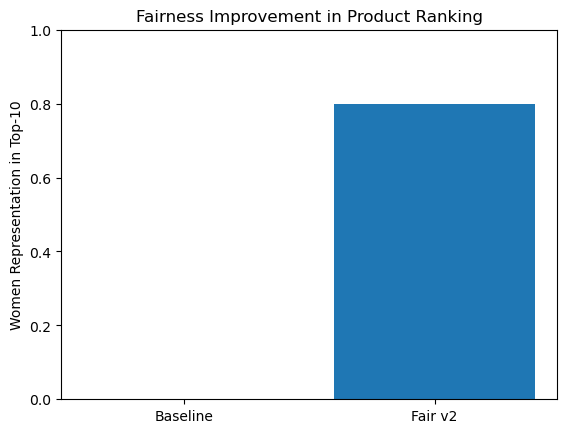

In [23]:
import matplotlib.pyplot as plt

labels = ["Baseline", "Fair v2"]
women_percent = [0.0, 0.8]

plt.bar(labels, women_percent)
plt.ylabel("Women Representation in Top-10")
plt.title("Fairness Improvement in Product Ranking")
plt.ylim(0, 1)
plt.show()


In [24]:
import sys
sys.path.append("../src")

from fair_ranking import fair_rank

In [25]:
ranked_df = fair_rank(train_df)
ranked_df.head(10)[["title", "maincateg", "fair_score"]]

,title,maincateg,fair_score
947,"Elasto-02 Navy Pink Walking Shoes,Slipon Shoes...",Women,0.935922
4608,Elasto-02 Navy Maroon Running Shoes For Women ...,Women,0.935922
10189,"Elasto-02 Peach Pink Walking Shoes,Slipon Shoe...",Women,0.933881
9918,Elasto-02 Navy Maroon Running Shoes For Women ...,Women,0.933881
5664,"Walking Shoes For Women (Black, Orange)",Women,0.933881
8508,Elasto-02 Grey Black Running Shoes For Women ...,Women,0.933881
671,"Elasto-02 Peach Pink Walking Shoes,Slipon Shoe...",Women,0.933881
14604,"Walking Shoes For Women (Pink, Grey)",Women,0.933881
7988,WNDR-13 Running Shoes For Men (White),Men,0.927991
4339,WNDR-13 Running Shoes For Men (White),Men,0.927991
